# NHL Defensemen Clustering

This file is used to cluster the NHL Defensemen into tiers.



## Import Libraries

In [40]:
import pandas as pd
import numpy as np
import os

## Defensemen Clustering

In [41]:
# Load Defensemen
nhl_defensemen = pd.read_csv('../dataset/preprocess/nhl_defensemen.csv')

In [42]:
nhl_defensemen

,player_id,player_name_official,seasons_played,seasons_with_gp_over_6,gp_regular_total,gp_regular_min_per_season,gp_regular_max_per_season,g_regular_sum,a_regular_sum,p_regular_sum,...,nation,height_cm,weight_kg,shoots,player_type,nhl_rights,draft,highlights,description,age_by_2025
0,6.0,Ray Bourque,22,22,1612.0,14.0,82.0,410.0,1169.0,1579.0,...,Canada,180,98,L,"['Heavy Shooter', 'Offensive Defenseman']",NaN,"('1', '8', '1979')","['2-time Canada Cup Champion', '1-time Hockey ...",Brother: Richard Bourque\r\nSons: Chris Bourqu...,64
1,9.0,Martin Skoula,10,10,776.0,17.0,82.0,44.0,152.0,196.0,...,Czechia,190,101,L,NaN,NaN,"('1', '17', '1998')","['1-time World Championship Silver Medal', '1-...",Škoula was a big defenseman with all-around ab...,45
2,11.0,Greg De Vries,13,13,878.0,6.0,82.0,48.0,146.0,194.0,...,Canada,190,95,L,NaN,NaN,NaN,['1-time NHL Stanley Cup Champion'],Son: Luke De Vries\r\nNephew: Nate Tivey,52
3,13.0,Jon Klemm,15,13,773.0,4.0,82.0,42.0,100.0,142.0,...,Canada,188,92,R,NaN,NaN,NaN,"['1-time CHL Memorial Cup Champion', '2-time N...",NaN,55
4,14.0,Adam Foote,19,19,1154.0,12.0,81.0,66.0,242.0,308.0,...,Canada,188,103,R,['Defensive Defenseman'],NaN,"('2', '22', '1989')","['1-time Olympic Gold Medal', '1-time World Cu...","Sons: Cal Foote, Nolan Foote",54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
829,3876.0,Adam Burt,13,12,737.0,5.0,78.0,37.0,115.0,152.0,...,USA,188,93,L,NaN,NaN,"('2', '39', '1987')",['1-time OHL Second All-Star Team'],NaN,56
830,3878.0,David Harlock,8,4,212.0,1.0,70.0,2.0,14.0,16.0,...,Canada,188,88,L,NaN,NaN,"('2', '24', '1990')",['1-time Olympic Silver Medal'],NaN,54
831,3889.0,Matt Jones,3,3,106.0,16.0,45.0,1.0,10.0,11.0,...,USA,183,98,L,NaN,NaN,"('3', '80', '2002')",['1-time USHL Clark Cup Champion'],Brother: Zach Jones,42
832,3896.0,Boris Valabik,3,3,80.0,7.0,50.0,0.0,7.0,7.0,...,Slovakia,201,105,L,"['Defensive Defenseman', 'Enforcer', 'Heavy Hi...",NaN,"('1', '10', '2004')","['1-time U18 WJC Silver Medal', '1-time AHL Ca...",A defenseman with a physical style. Useful in ...,39


### Processing Stats Attributes (numeric)

- Select numeric columns

- Standardize them

In [43]:
from sklearn.preprocessing import StandardScaler

# Select numeric columns
stats_cols = [
    "gp_regular_total", "gp_regular_min_per_season", "gp_regular_max_per_season",
    "g_regular_sum", "a_regular_sum", "p_regular_sum", "plus_minus_regular_sum", "pim_regular_sum",
    "ppg_regular_sum", "ppp_regular_sum", "shg_regular_sum", "shp_regular_sum",
    "gwg_regular_sum", "otg_regular_sum", "sog_regular_sum",
    "shooting_pct_regular_mean", "fo_pct_regular_mean", "toi_per_game_regular_mean",
    "g_regular_per_game", "a_regular_per_game", "p_regular_per_game",
    "sog_regular_per_game", "pim_regular_per_game",
    "gp_playoffs_sum", "g_playoffs_sum", "a_playoffs_sum", "p_playoffs_sum", "plus_minus_playoffs_sum", "pim_playoffs_sum",
    "ppg_playoffs_sum", "ppp_playoffs_sum", "shg_playoffs_sum", "shp_playoffs_sum",
    "gwg_playoffs_sum", "otg_playoffs_sum", "sog_playoffs_sum",
    "shooting_pct_playoffs_mean", "fo_pct_playoffs_mean", "toi_per_game_playoffs_mean",
    "g_playoffs_per_game", "a_playoffs_per_game", "p_playoffs_per_game",
    "sog_playoffs_per_game", "pim_playoffs_per_game"
]

# Fill missing values with 0
nhl_defensemen[stats_cols] = nhl_defensemen[stats_cols].fillna(0)

# Standardize numeric columns
scaler = StandardScaler()
X_stats_scaled = scaler.fit_transform(nhl_defensemen[stats_cols])

## Categorical Encoding

- `nation` and `shoots`, `player_type` -> One-hot encoding

- `draft`

    - Convert into structured features: round, overall, year

- `highlights`

    - Treat as multi-label categorical

    - Convert to binary indicators (bag-of-words style).

In [44]:
# Handle Nation and Shoots by One-hot encoding
from sklearn.preprocessing import OneHotEncoder

onehot_cols = ['nation', 'shoots']
ohe = OneHotEncoder(handle_unknown="ignore")
X_onehot = ohe.fit_transform(nhl_defensemen[onehot_cols])

In [45]:
import ast

# Step 1: Ensure player_type column is always a list
def parse_types(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)  # safely evaluate string representation of list
        except (ValueError, SyntaxError):
            return [x.strip()] if x.strip() else []
    return []

nhl_defensemen['player_type'] = nhl_defensemen['player_type'].apply(parse_types)

# Step 2: Get all unique player types
all_types = sorted(set(pt for types in nhl_defensemen['player_type'] for pt in types))

# Step 3: One-hot encode player types
for pt in all_types:
    col_name = f"player_type_{pt.replace(' ', '_').lower()}"
    nhl_defensemen[col_name] = nhl_defensemen['player_type'].apply(lambda x: int(pt in x))

# Step 4: Select the one-hot encoded columns
X_player_type = nhl_defensemen[[col for col in nhl_defensemen.columns if col.startswith("player_type_")]]

In [46]:
# Handle Draft
nhl_defensemen['draft_round'] = nhl_defensemen['draft'].dropna().apply(lambda x: int(eval(x)[0]) if pd.notnull(x) else None)
nhl_defensemen['draft_overall'] = nhl_defensemen['draft'].dropna().apply(lambda x: int(eval(x)[1]) if pd.notnull(x) else None)
nhl_defensemen['draft_year'] = nhl_defensemen['draft'].dropna().apply(lambda x: int(eval(x)[2]) if pd.notnull(x) else None)


In [47]:
# Extract Draft Features into X_draft
draft_cols = ['draft_round', 'draft_overall', 'draft_year']
X_draft = nhl_defensemen[draft_cols].values

In [48]:
nhl_defensemen.shape

(834, 93)

### Handle Highlights

1. Normalize the highlights columns

2. Extract Award Features

3. Aggregate to General Award Metrics

In [49]:
import ast
import re
import pandas as pd

# Load your Excel file
df_awards = pd.read_csv("../dataset/nhl_players_metadata_facts_merged_final.csv")

# Convert stringified lists into actual lists
df_awards["highlights"] = df_awards["highlights"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Flatten all highlights into a single list
all_highlights = [item for sublist in df_awards["highlights"] for item in sublist]

# Regex pattern: matches "1-time " or "2-time " etc. at the start
pattern = re.compile(r"^\d+-time\s+")

# Extract NHL related awards
all_highlights = [h for h in all_highlights if "NHL" in h]

# Normalize award names
normalized_awards = [pattern.sub("", h).strip() for h in all_highlights]

# Extract unique award names
unique_awards = sorted(set(normalized_awards))

# Show them
for award in unique_awards:
    print(award)


NHL 4 Nations Champion
NHL 4 Nations MVP
NHL 4 Nations Most Points
NHL All-Rookie Team
NHL Best Defenseman (Norris Trophy)
NHL Contribution to U.S. Hockey (Lester Patrick Trophy)
NHL First All-Star Team
NHL Foundation Player Award
NHL Gentleman Conduct (Lady Byng Trophy)
NHL Leadership-Humanitarian Award (King Clancy Trophy)
NHL MVP Selected by NHLPA (Ted Lindsay Award)
NHL Mark Messier Leadership Award
NHL Most Assists
NHL Most Goals (Maurice Richard Trophy)
NHL Most Points (Art Ross Trophy)
NHL Most Valuable Player (Hart Trophy)
NHL Rookie of the Year (Calder Trophy)
NHL Second All-Star Team
NHL Sportsmanship Award (Bill Masterton Trophy)
NHL Stanley Cup Champion
NHL Stanley Cup MVP (Conn Smythe Trophy)
NHL Top Defensive Forward (Frank J. Selke Trophy)


In [50]:
import re

# Define NHL-related awards
# Define NHL-related awards keywords from all_highlights
award_keywords = {
    # Neglect 4 Nations awards
    # "4nations_champion": "NHL 4 Nations Champion",
    # "4nations_mvp": "NHL 4 Nations MVP",
    # "4nations_points": "NHL 4 Nations Most Points",
    "all_rookie": "NHL All-Rookie Team",
    "norris": "NHL Best Defenseman (Norris Trophy)",
    "patrick": "NHL Contribution to U.S. Hockey (Lester Patrick Trophy)",
    "all_star_first": "NHL First All-Star Team",
    "foundation": "NHL Foundation Player Award",
    "lady_byng": "NHL Gentleman Conduct (Lady Byng Trophy)",
    "king_clancy": "NHL Leadership-Humanitarian Award (King Clancy Trophy)",
    "ted_lindsay": "NHL MVP Selected by NHLPA (Ted Lindsay Award)",
    "messier": "NHL Mark Messier Leadership Award",
    "most_assists": "NHL Most Assists",
    "richard": "NHL Most Goals (Maurice Richard Trophy)",
    "art_ross": "NHL Most Points (Art Ross Trophy)",
    "hart": "NHL Most Valuable Player (Hart Trophy)",
    "calder": "NHL Rookie of the Year (Calder Trophy)",
    "all_star_second": "NHL Second All-Star Team",
    "masterton": "NHL Sportsmanship Award (Bill Masterton Trophy)",
    "stanley_cup": "NHL Stanley Cup Champion",
    "conn_smythe": "NHL Stanley Cup MVP (Conn Smythe Trophy)",
    "selke": "NHL Top Defensive Forward (Frank J. Selke Trophy)",
    "hhof": "Hockey Hall of Fame"
}

def extract_awards(awards_list):
    """Count NHL-related awards for a player."""
    award_counts = {key: 0 for key in award_keywords.keys()}

    if pd.isna(awards_list):
        return award_counts

    # Convert stringified list to list if necessary
    if isinstance(awards_list, str):
        try:
            awards_list = eval(awards_list)
        except:
            awards_list = [awards_list]

    for award in awards_list:
        text = str(award).lower()
        for key, phrase in award_keywords.items():
            if phrase.lower() in text:
                # Check for counts like "5-time" or "2-time"
                match = re.search(r"(\d+)[- ]?time", text)
                count = int(match.group(1)) if match else 1
                award_counts[key] += count

    return award_counts

# Apply the function to the highlights column
award_features = nhl_defensemen['highlights'].apply(extract_awards).apply(pd.Series)

# Merge the award counts back into the main dataframe
nhl_defensemen = pd.concat([nhl_defensemen, award_features], axis=1)

# Fill NaNs with 0 for awards
nhl_defensemen[award_features.columns] = nhl_defensemen[award_features.columns].fillna(0)

# Show the first 5 players
nhl_defensemen.head()

,player_id,player_name_official,seasons_played,seasons_with_gp_over_6,gp_regular_total,gp_regular_min_per_season,gp_regular_max_per_season,g_regular_sum,a_regular_sum,p_regular_sum,...,richard,art_ross,hart,calder,all_star_second,masterton,stanley_cup,conn_smythe,selke,hhof
0,6.0,Ray Bourque,22,22,1612.0,14.0,82.0,410.0,1169.0,1579.0,...,0,0,0,1,6,0,1,0,0,1
1,9.0,Martin Skoula,10,10,776.0,17.0,82.0,44.0,152.0,196.0,...,0,0,0,0,0,0,1,0,0,0
2,11.0,Greg De Vries,13,13,878.0,6.0,82.0,48.0,146.0,194.0,...,0,0,0,0,0,0,1,0,0,0
3,13.0,Jon Klemm,15,13,773.0,4.0,82.0,42.0,100.0,142.0,...,0,0,0,0,0,0,2,0,0,0
4,14.0,Adam Foote,19,19,1154.0,12.0,81.0,66.0,242.0,308.0,...,0,0,0,0,0,0,2,0,0,0


In [51]:
# Extract Award Features into X_highlights
award_cols = award_features.columns

X_highlights = nhl_defensemen[award_cols].values

## Combine All Features

- Combine `X_stats_scaled`, `X_onehot`, `X_draft`, `X_player_type`, and `X_highlights`

In [13]:
from scipy.sparse import hstack

X_combined = hstack([X_stats_scaled, X_onehot, X_draft, X_player_type, X_highlights])

## Dimensionality Reduction

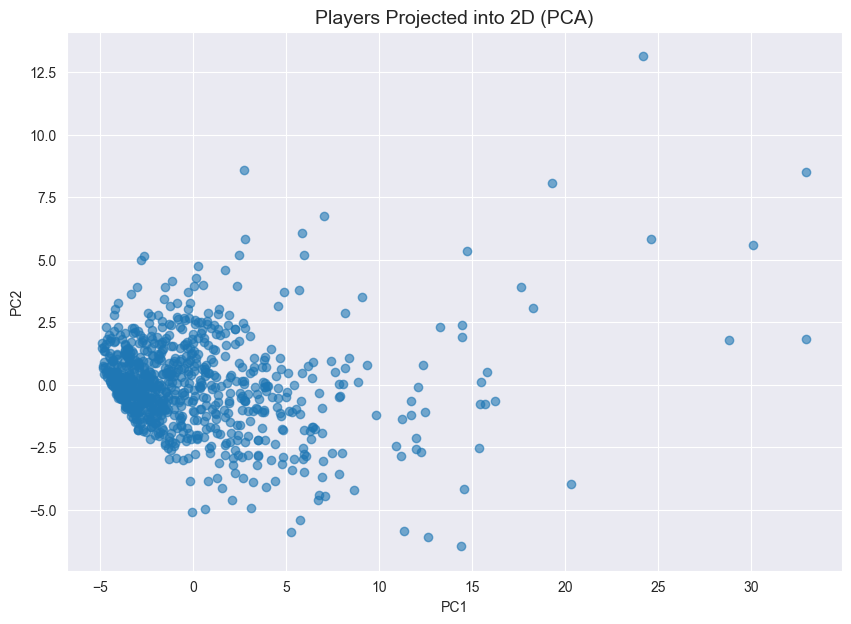

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Use numeric stats as features (already scaled)
# X = nhl_defensemen[stats_cols].values

# Step 1: Combine numeric (scaled), categorical (one-hot), and maybe highlights
X_combined = hstack([X_stats_scaled, X_onehot, X_highlights])

# Reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined)

# Plot
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6)
plt.title("Players Projected into 2D (PCA)", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


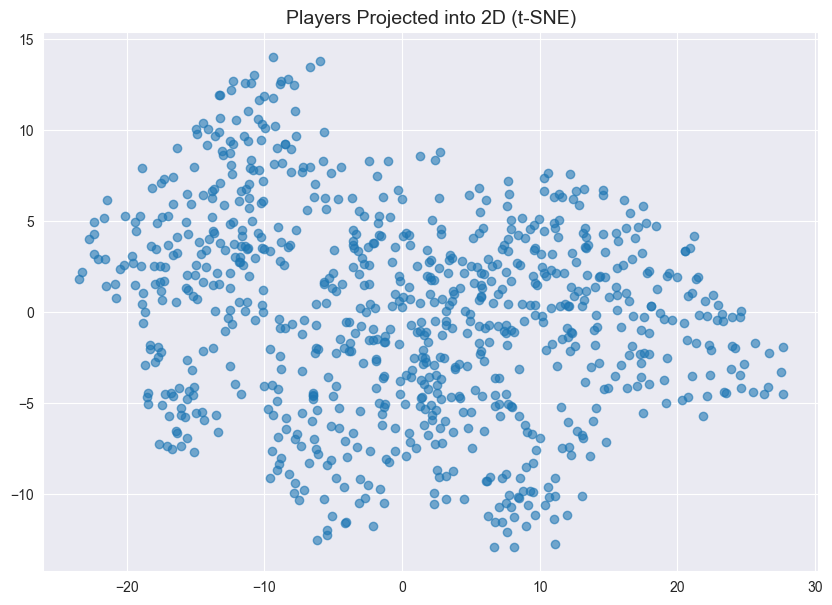

In [15]:
from sklearn.manifold import TSNE

# AgglomerativeClustering does not accept sparse matrices -> convert to dense
X_dense = X_combined.toarray()

X_tsne = TSNE(n_components=3, perplexity=30, random_state=42).fit_transform(X_dense)

plt.figure(figsize=(10, 7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.6)
plt.title("Players Projected into 2D (t-SNE)", fontsize=14)
plt.show()


## Clustering

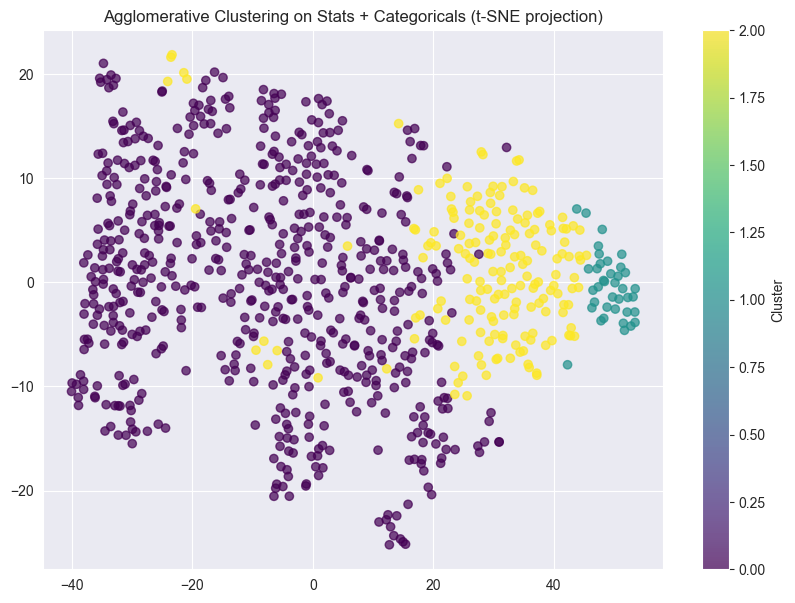

In [16]:
from scipy.sparse import hstack
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Step 1: Combine numeric (scaled), categorical (one-hot), and maybe highlights
X_combined = hstack([X_stats_scaled, X_onehot, X_highlights])

# AgglomerativeClustering does not accept sparse matrices -> convert to dense
X_dense = X_combined.toarray()

# Step 2: Cluster in high-dimensional space
agg = AgglomerativeClustering(n_clusters=3)
labels = agg.fit_predict(X_dense)

# Add cluster labels back to DataFrame
nhl_defensemen['cluster'] = labels

# Step 3: Project to 2D with t-SNE for visualization
X_tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X_dense)

# Step 4: Plot
plt.figure(figsize=(10, 7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap="viridis", alpha=0.7)
plt.colorbar(label='Cluster')
plt.title("Agglomerative Clustering on Stats + Categoricals (t-SNE projection)")
plt.show()

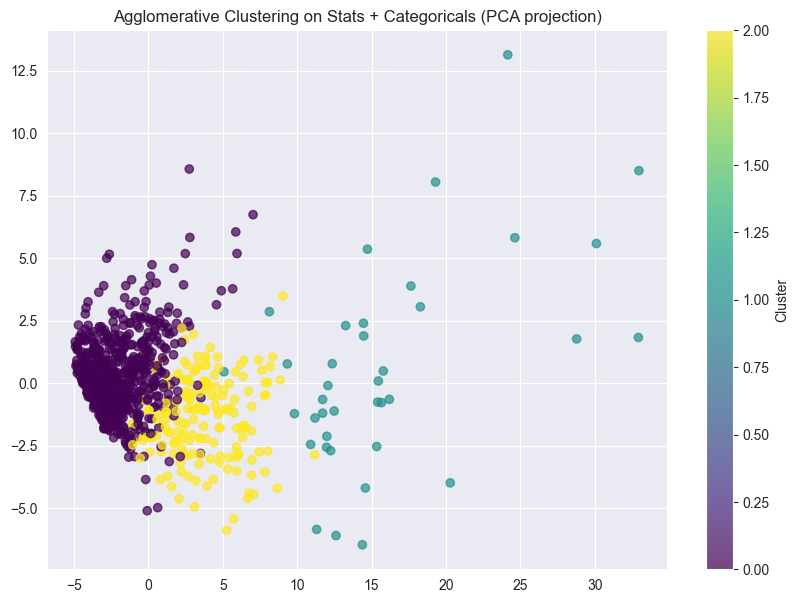

In [17]:
# Plot the clustering result using PCA
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="viridis", alpha=0.7)
plt.colorbar(label='Cluster')
plt.title("Agglomerative Clustering on Stats + Categoricals (PCA projection)")
plt.show()

In [18]:
# Show the average p_regular_per_season for each cluster
nhl_defensemen.groupby('cluster')['p_regular_per_season'].mean()

cluster
0     9.705805
1    44.526432
2    27.816869
Name: p_regular_per_season, dtype: float64

In [19]:
# Assign Tiers
tiers = {
    1: 1, # tier 1
    2: 2, # tier 2
    0: 3 # tier 3
}

nhl_defensemen['tier'] = nhl_defensemen['cluster'].map(tiers)

# Drop Cluster
nhl_defensemen.drop(['cluster'], axis=1, inplace=True)

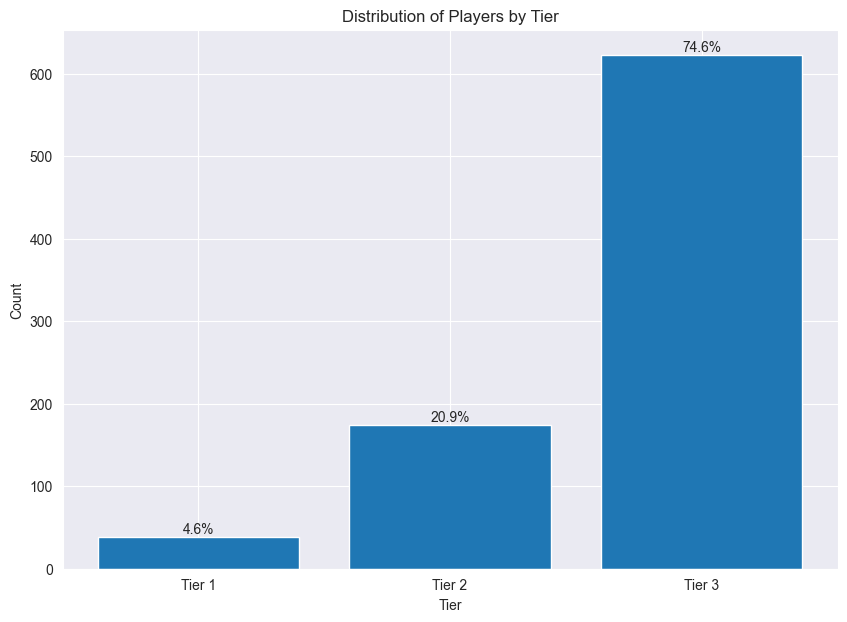

In [20]:
import matplotlib.pyplot as plt

# Calculate counts and percentages
tier_counts = nhl_defensemen['tier'].value_counts().sort_index()
tier_percentages = tier_counts / len(nhl_defensemen) * 100

# Plot bar chart instead of histogram
plt.figure(figsize=(10, 7))
bars = plt.bar(tier_counts.index, tier_counts.values, tick_label=[f"Tier {i}" for i in tier_counts.index])

# Annotate with percentages
for bar, pct in zip(bars, tier_percentages):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f"{pct:.1f}%",
             ha='center', va='bottom', fontsize=10)

plt.title("Distribution of Players by Tier")
plt.xlabel("Tier")
plt.ylabel("Count")
plt.show()

In [22]:
# Find Cale Makar
cale_makar = nhl_defensemen[nhl_defensemen['player_name_official'] == 'Cale Makar']
cale_makar["tier"]

60    1
Name: tier, dtype: int64

In [23]:
# Find Erik Karlsson
erik_karlsson = nhl_defensemen[nhl_defensemen['player_name_official'] == 'Erik Karlsson']
erik_karlsson["tier"]

745    1
Name: tier, dtype: int64

In [24]:
nhl_defensemen[nhl_defensemen['tier'] == 1]

,player_id,player_name_official,seasons_played,seasons_with_gp_over_6,gp_regular_total,gp_regular_min_per_season,gp_regular_max_per_season,g_regular_sum,a_regular_sum,p_regular_sum,...,art_ross,hart,calder,all_star_second,masterton,stanley_cup,conn_smythe,selke,hhof,tier
0,6.0,Ray Bourque,22,22,1612.0,14.0,82.0,410.0,1169.0,1579.0,...,0,0,1,6,0,1,0,0,1,1
6,18.0,Rob Blake,20,18,1270.0,4.0,84.0,240.0,537.0,777.0,...,0,0,0,3,0,1,0,0,1,1
60,234.0,Cale Makar,6,6,395.0,44.0,80.0,116.0,312.0,428.0,...,0,0,1,2,0,1,1,0,0,1
89,348.0,Phil Housley,21,21,1495.0,1.0,80.0,338.0,894.0,1232.0,...,0,0,0,1,0,0,0,0,2,1
102,389.0,Brent Seabrook,15,15,1114.0,32.0,82.0,103.0,361.0,464.0,...,0,0,0,0,0,3,0,0,0,1
103,392.0,Duncan Keith,17,17,1256.0,47.0,82.0,106.0,540.0,646.0,...,0,0,0,1,0,3,1,0,1,1
215,888.0,Al Macinnis,23,21,1416.0,2.0,82.0,340.0,934.0,1274.0,...,0,0,0,3,0,1,1,0,1,1
216,889.0,Chris Pronger,18,17,1167.0,5.0,82.0,157.0,541.0,698.0,...,0,1,0,3,0,1,0,0,1,1
241,986.0,Alex Pietrangelo,17,17,1087.0,8.0,81.0,148.0,489.0,637.0,...,0,0,0,3,0,2,0,0,0,1
271,1111.0,Paul Coffey,21,21,1409.0,10.0,80.0,396.0,1135.0,1531.0,...,0,0,0,4,0,4,0,0,1,1


### Further Clustering the tier 3 players

Tier 3 defensemen count: 622
Feature dimensions: (622, 110)


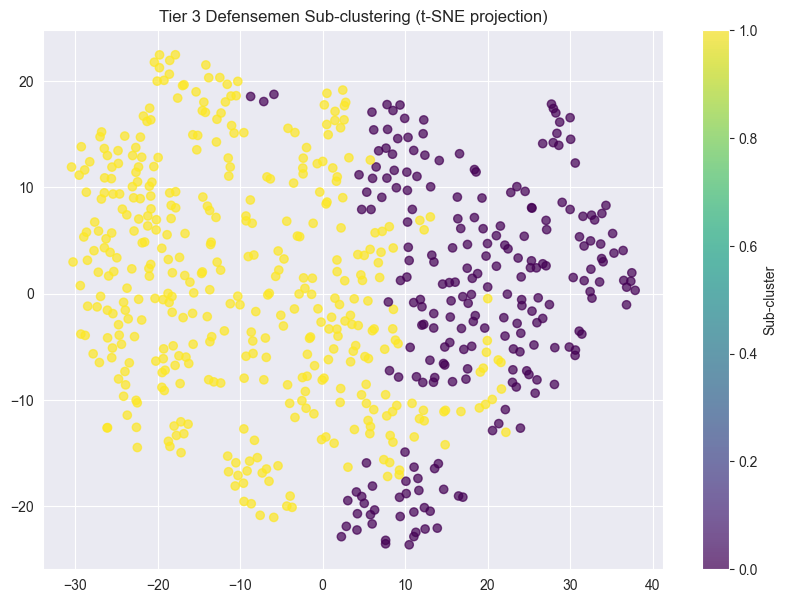

In [25]:
# Get tier 3 defensemen indices
tier_3_indices = nhl_defensemen[nhl_defensemen['tier'] == 3].index

# Extract the corresponding features from the already encoded data
X_tier_3 = X_dense[tier_3_indices]

print(f"Tier 3 defensemen count: {len(tier_3_indices)}")
print(f"Feature dimensions: {X_tier_3.shape}")

# Perform sub-clustering on tier 3 players
from sklearn.cluster import AgglomerativeClustering

# Use fewer clusters for the subset
agg_tier3 = AgglomerativeClustering(n_clusters=2)
tier3_labels = agg_tier3.fit_predict(X_tier_3)

# Create sub-tiers (3a, 3b)
tier_3_defensemen = nhl_defensemen[nhl_defensemen['tier'] == 3].copy()
tier_3_defensemen['sub_tier'] = ['3a' if label == 0 else '3b' for label in tier3_labels]

# Visualize the sub-clustering
X_tier3_tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(tier_3_indices)//3)).fit_transform(X_tier_3)

plt.figure(figsize=(10, 7))
plt.scatter(X_tier3_tsne[:, 0], X_tier3_tsne[:, 1], c=tier3_labels, cmap="viridis", alpha=0.7)
plt.colorbar(label='Sub-cluster')
plt.title("Tier 3 Defensemen Sub-clustering (t-SNE projection)")
plt.show()

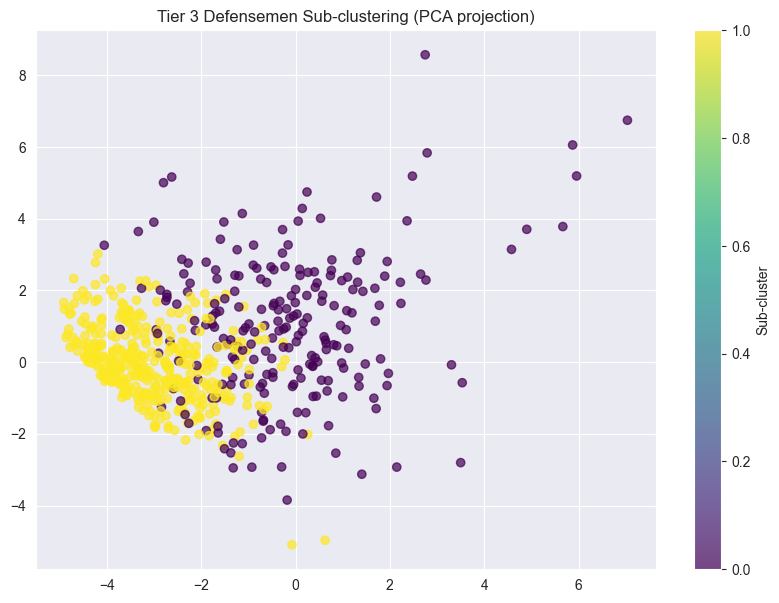

In [26]:
# Plot the sub-clustering result using PCA
X_tier3_pca = pca.transform(X_tier_3)

plt.figure(figsize=(10, 7))
plt.scatter(X_tier3_pca[:, 0], X_tier3_pca[:, 1], c=tier3_labels, cmap="viridis", alpha=0.7)
plt.colorbar(label='Sub-cluster')
plt.title("Tier 3 Defensemen Sub-clustering (PCA projection)")
plt.show()

In [27]:
# Show the average g_regular_per_season of each sub_tier
tier_3_defensemen.groupby('sub_tier')['p_regular_per_season'].mean()

sub_tier
3a    12.858341
3b     7.931514
Name: p_regular_per_season, dtype: float64

In [28]:
# Show the 3a and 3b counts and percentages
tier_3_defensemen['sub_tier'].value_counts()

sub_tier
3b    398
3a    224
Name: count, dtype: int64

In [29]:
# Change tier 3b to tier 4
tier_3_defensemen['tier'] = tier_3_defensemen['sub_tier'].apply(lambda x: 4 if x == '3b' else 3)

In [30]:
# Modified the tier in nhl_defensemen
nhl_defensemen.loc[tier_3_indices, 'tier'] = tier_3_defensemen['tier'].values

In [31]:
nhl_defensemen

,player_id,player_name_official,seasons_played,seasons_with_gp_over_6,gp_regular_total,gp_regular_min_per_season,gp_regular_max_per_season,g_regular_sum,a_regular_sum,p_regular_sum,...,art_ross,hart,calder,all_star_second,masterton,stanley_cup,conn_smythe,selke,hhof,tier
0,6.0,Ray Bourque,22,22,1612.0,14.0,82.0,410.0,1169.0,1579.0,...,0,0,1,6,0,1,0,0,1,1
1,9.0,Martin Skoula,10,10,776.0,17.0,82.0,44.0,152.0,196.0,...,0,0,0,0,0,1,0,0,0,4
2,11.0,Greg De Vries,13,13,878.0,6.0,82.0,48.0,146.0,194.0,...,0,0,0,0,0,1,0,0,0,3
3,13.0,Jon Klemm,15,13,773.0,4.0,82.0,42.0,100.0,142.0,...,0,0,0,0,0,2,0,0,0,3
4,14.0,Adam Foote,19,19,1154.0,12.0,81.0,66.0,242.0,308.0,...,0,0,0,0,0,2,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
829,3876.0,Adam Burt,13,12,737.0,5.0,78.0,37.0,115.0,152.0,...,0,0,0,0,0,0,0,0,0,3
830,3878.0,David Harlock,8,4,212.0,1.0,70.0,2.0,14.0,16.0,...,0,0,0,0,0,0,0,0,0,4
831,3889.0,Matt Jones,3,3,106.0,16.0,45.0,1.0,10.0,11.0,...,0,0,0,0,0,0,0,0,0,4
832,3896.0,Boris Valabik,3,3,80.0,7.0,50.0,0.0,7.0,7.0,...,0,0,0,0,0,0,0,0,0,4


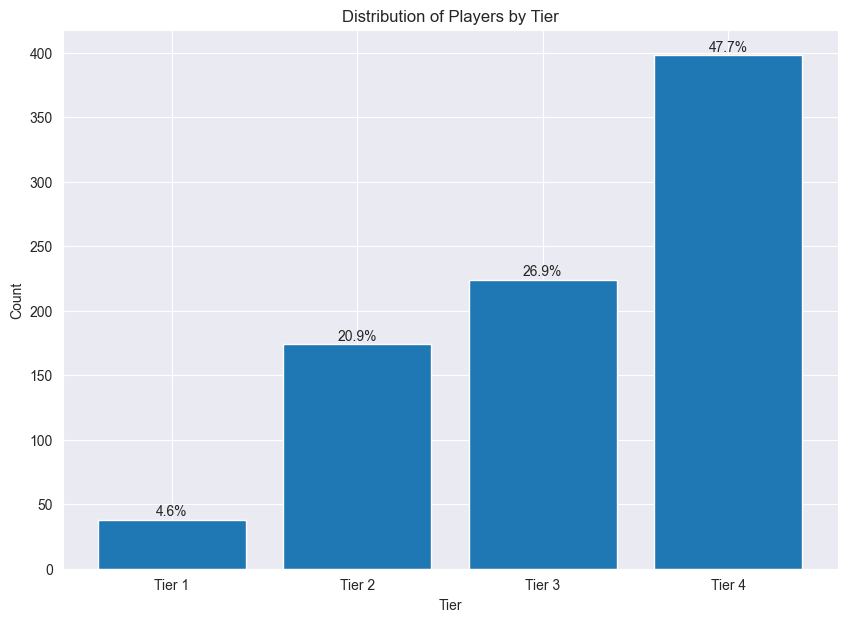

In [32]:
import matplotlib.pyplot as plt

# Calculate counts and percentages
tier_counts = nhl_defensemen['tier'].value_counts().sort_index()
tier_percentages = tier_counts / len(nhl_defensemen) * 100

# Plot bar chart instead of histogram
plt.figure(figsize=(10, 7))
bars = plt.bar(tier_counts.index, tier_counts.values, tick_label=[f"Tier {i}" for i in tier_counts.index])

# Annotate with percentages
for bar, pct in zip(bars, tier_percentages):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f"{pct:.1f}%",
             ha='center', va='bottom', fontsize=10)

plt.title("Distribution of Players by Tier")
plt.xlabel("Tier")
plt.ylabel("Count")
plt.show()

In [33]:
# Show the average p_regular_per_season of each tier
nhl_defensemen.groupby('tier')['p_regular_per_season'].mean()

tier
1    44.526432
2    27.816869
3    12.858341
4     7.931514
Name: p_regular_per_season, dtype: float64

In [39]:
# Show the count of each tier
nhl_defensemen['tier'].value_counts()

tier
4    398
3    224
2    174
1     38
Name: count, dtype: int64

## Write to CSV

In [34]:
# Write to CSV
nhl_defensemen.to_csv('../dataset/preprocess/nhl_defensemen_with_tiers.csv', index=False, encoding='utf-8-sig')

In [35]:
# Show the tier1 players
nhl_defensemen[nhl_defensemen['tier'] == 1]

,player_id,player_name_official,seasons_played,seasons_with_gp_over_6,gp_regular_total,gp_regular_min_per_season,gp_regular_max_per_season,g_regular_sum,a_regular_sum,p_regular_sum,...,art_ross,hart,calder,all_star_second,masterton,stanley_cup,conn_smythe,selke,hhof,tier
0,6.0,Ray Bourque,22,22,1612.0,14.0,82.0,410.0,1169.0,1579.0,...,0,0,1,6,0,1,0,0,1,1
6,18.0,Rob Blake,20,18,1270.0,4.0,84.0,240.0,537.0,777.0,...,0,0,0,3,0,1,0,0,1,1
60,234.0,Cale Makar,6,6,395.0,44.0,80.0,116.0,312.0,428.0,...,0,0,1,2,0,1,1,0,0,1
89,348.0,Phil Housley,21,21,1495.0,1.0,80.0,338.0,894.0,1232.0,...,0,0,0,1,0,0,0,0,2,1
102,389.0,Brent Seabrook,15,15,1114.0,32.0,82.0,103.0,361.0,464.0,...,0,0,0,0,0,3,0,0,0,1
103,392.0,Duncan Keith,17,17,1256.0,47.0,82.0,106.0,540.0,646.0,...,0,0,0,1,0,3,1,0,1,1
215,888.0,Al Macinnis,23,21,1416.0,2.0,82.0,340.0,934.0,1274.0,...,0,0,0,3,0,1,1,0,1,1
216,889.0,Chris Pronger,18,17,1167.0,5.0,82.0,157.0,541.0,698.0,...,0,1,0,3,0,1,0,0,1,1
241,986.0,Alex Pietrangelo,17,17,1087.0,8.0,81.0,148.0,489.0,637.0,...,0,0,0,3,0,2,0,0,0,1
271,1111.0,Paul Coffey,21,21,1409.0,10.0,80.0,396.0,1135.0,1531.0,...,0,0,0,4,0,4,0,0,1,1


In [36]:
# Show the tier2 players
nhl_defensemen[nhl_defensemen['tier'] == 2]

,player_id,player_name_official,seasons_played,seasons_with_gp_over_6,gp_regular_total,gp_regular_min_per_season,gp_regular_max_per_season,g_regular_sum,a_regular_sum,p_regular_sum,...,art_ross,hart,calder,all_star_second,masterton,stanley_cup,conn_smythe,selke,hhof,tier
14,44.0,Derek Morris,16,16,1107.0,14.0,82.0,92.0,332.0,424.0,...,0,0,0,0,0,0,0,0,0,2
16,57.0,John-Michael Liles,13,13,836.0,6.0,82.0,87.0,283.0,370.0,...,0,0,0,0,0,0,0,0,0,2
22,79.0,Patrice Brisebois,18,18,1009.0,10.0,80.0,98.0,322.0,420.0,...,0,0,0,0,0,1,0,0,0,2
29,103.0,Johnny Boychuk,13,11,725.0,1.0,77.0,54.0,152.0,206.0,...,0,0,0,0,0,1,0,0,0,2
34,131.0,Kevin Shattenkirk,14,14,952.0,19.0,82.0,103.0,381.0,484.0,...,0,0,0,0,0,1,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,3692.0,Marc-Edouard Vlasic,19,19,1323.0,27.0,82.0,84.0,295.0,379.0,...,0,0,0,0,0,0,0,0,0,2
818,3781.0,Miro Heiskanen,7,7,475.0,50.0,82.0,58.0,225.0,283.0,...,0,0,0,0,0,0,0,0,0,2
823,3830.0,Jared Spurgeon,15,15,933.0,16.0,82.0,117.0,299.0,416.0,...,0,0,0,0,0,0,0,0,0,2
824,3841.0,Jonas Brodin,13,13,853.0,45.0,82.0,58.0,202.0,260.0,...,0,0,0,0,0,0,0,0,0,2


In [ ]:
# Show the tier4 players
nhl_defensemen[nhl_defensemen['tier'] == 4]
